# Examine The Blocking and Matcher Results from experiments

In [2]:
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score,roc_auc_score, auc
from evaluation_functions import *
import statsmodels.api as sm 
from statsmodels.formula.api import ols

# TODO: work out how to genearted matching results when using LSH as a matcher
# TODO validate metrics like end to end recall

result = pickle.load(open("../results/magellan_Jul_20_2017.p","rb"))
blocking_results = blocking_results_with_meta(result)
matcher_results = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df)


result = pickle.load(open("../results/deep_matcher_Jul_22_2347_5000bands.p","rb"))
matcher_results_deep = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df, is_deep_matcher= True, bands = 5000)

result = pickle.load(open("../results/deep_matcher_hybrid_Jul_23_1630_5000bands.p","rb"))
matcher_results_deep_hybrid = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df, is_deep_matcher= True, bands = 5000)

# load in run under 2500 bands
result = pickle.load(open("../results/deep_matcher_iterative_2500bands.p","rb"))
matcher_iterative= matcher_results_with_meta(result, blocking_results.missed_positive_matches_df, is_deep_matcher= True , bands = 2500)


result = pickle.load(open("../results/hybrid_deep_matcher_naive_2500bands.p","rb"))
matcher_hybrid_naive = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df, is_deep_matcher= True , bands = 2500)

# Add last one for the remmainder of naive deepmatcher models at 2500bands
result = pickle.load(open("../results/sif_rnn_deep_matcher_naive_2500bands.p","rb"))
matcher_sif_rnn_naive = matcher_results_with_meta(result, blocking_results.missed_positive_matches_df, is_deep_matcher= True , bands = 2500)


matcher_results = pd.concat([matcher_results,matcher_results_deep,matcher_results_deep_hybrid,matcher_hybrid_naive,matcher_sif_rnn_naive, matcher_iterative])

# Mergin results
all_results = pd.merge(matcher_results, blocking_results,left_index = True, right_index = True, suffixes = ("_m","_b"))

# # Validate this????????
# all_results["best_case_overall_recall"] = all_results.test_recall_b * all_results.test_recall_m.apply(np.max)



# Questions I need To answer


* Which blocking algorithm recalls the best? -- DONE
* Do the algorithms which recall the best create dataset sizes that are manageable? -- DONE for top 5

* Does sampling iteratively improve final precision and recall? -- DONE.. anova says nah not really
* Which model is the best to use as a matcher? --- Done

* Comment on 5000 --> 2500 bands performance decrease for all models

* Which set of systems is the most robust/easiest for the layman?


# Evaluate Blocking Performance

## Recall

In [3]:
blocking_results["id"] = blocking_results.index

blocking_stats = {"value":[np.mean,np.std]}

print(blocking_results.melt(id_vars = ["blocking_algo","id","sampler"], value_vars = ["train_recall","valid_recall","test_recall"]).groupby(["id","blocking_algo","sampler"]).agg(blocking_stats).columns)
# Compute Top 5 wrt blocking recall
top_5_blocking_recall = blocking_results.melt(id_vars = ["blocking_algo","id","sampler"], value_vars = ["train_recall","valid_recall","test_recall"]).groupby(["id","blocking_algo","sampler"]).agg(blocking_stats).nlargest(5,('value', 'mean'))

top_5_blocking_recall = top_5_blocking_recall.reset_index().set_index("id")
top_5_blocking_recall


MultiIndex([('value', 'mean'),
            ('value',  'std')],
           )


blocking_algo    sampler     value          
                                                         mean       std
id                                                                     
iterativelshNANA85000                lsh  iterative  0.970112  0.006510
iterativelshNANA82500                lsh  iterative  0.795007  0.036244
iterativesequential801NANA    sequential  iterative  0.786180  0.060992
iterativesequential802NANA    sequential  iterative  0.739003  0.043922
naivelshNANA85000                    lsh      naive  0.640111  0.404797

The LSH algorithm with large BIN sizes recalls the best. This is the mean. How does the sampling method affect variance of recall across sets?
Below is across ALL hyper-parameter choices

In [6]:
blocking_results.melt(id_vars = ["blocking_algo","id","sampler"], value_vars = ["train_recall","valid_recall","test_recall"]).groupby(["blocking_algo","sampler"]).agg(blocking_stats)

value          
                             mean       std
blocking_algo sampler                      
lsh           iterative  0.882560  0.098696
              naive      0.585884  0.333292
sequential    iterative  0.430650  0.213380
              naive      0.276725  0.207957

We can see above that irrespective of tuning hyper-parameters, for the blocking algorithms explored in this research, our iterative sampler has successfully managed to balance performance across all sets with comparable and heavily decreased in the case of LSH, std.


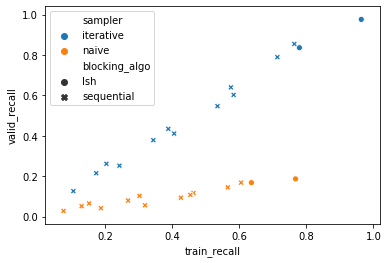

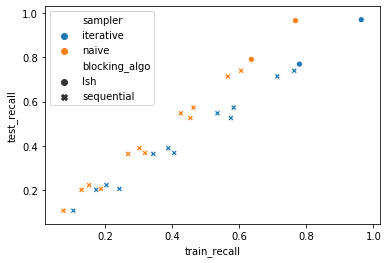

In [7]:
sns.scatterplot(x = blocking_results.train_recall, y = blocking_results.valid_recall, style = blocking_results.blocking_algo, hue = blocking_results.sampler)
plt.show()

sns.scatterplot(x = blocking_results.train_recall, y = blocking_results.test_recall, style = blocking_results.blocking_algo, hue = blocking_results.sampler)
plt.show()

## Pruning Power

Measure the percentage reduction from the total possible number of comparisons. Measures how computationally friendly each method is.

Raw Pruning

Average rate of recall increase with decreasing pruning power (across hyper-parameters per method)

In [18]:


long_pruning = blocking_results.melt(id_vars = ["blocking_algo","id"], value_vars = ["train_prune","valid_prune","test_prune"]).reset_index().set_index("id")

long_pruning_filtered = long_pruning.loc[long_pruning.index.isin(top_5_blocking_recall.index)]

# Reindex allows you to order by ANOTHER external list
long_pruning_filtered.groupby("id").agg(blocking_stats).reindex(index = top_5_blocking_recall.index)



value          
                                mean       std
id                                            
iterativelshNANA85000       0.927062  0.010588
iterativelshNANA82500       0.991675  0.002135
iterativesequential801NANA  0.807451  0.028159
iterativesequential802NANA  0.969615  0.005790
naivelshNANA85000           0.930592  0.013993

LSH at 500 bands has second worst pruning rate but it is by far not the worst!
if reducing the size is of CRITICAL importance, rather reduce number of bands than use the sequential method

# Recall

In [19]:
# Visualise some results




matcher_results.groupby(["sampler","blocking_algo"]).apply(np.mean)
matcher_results.groupby(["model","sampler","blocking_algo"]).apply(np.mean)
#NB
matcher_results.query("blocking_algo == 'lsh'").groupby(["model","sampler"]).apply(np.mean)


matcher_results["id"] = np.arange(matcher_results.shape[0])

plotting_data = pd.concat([matcher_results.loc[:,["sampler","id","test_precision"]].explode("test_precision"),matcher_results.loc[:,["test_recall"]].explode("test_recall")], axis = 1)

# Try anova


ols_fit = ols('test_average_precision ~ C(sampler) + C(model)',
               data=matcher_results.loc[:,["sampler","model","test_average_precision"]]).fit()
sm.stats.anova_lm(ols_fit, typ=2)



,sum_sq,df,F,PR(>F)
C(sampler),0.003900,1.0,0.090113,0.764733
C(model),0.608481,5.0,2.812190,0.020969
Residual,3.851430,89.0,NaN,NaN


Okay so if we look at it holistically, the sampling method does NOT improve test_average_precision.

However, what about decision making? Are we more likely to choose the BEST model if we use this sampling method? Idea is that it allows for better decision making



So should we go with a system with less blocking recall but better matching performance or the other way around?  Remember, the test precision quantity has been adjusted for positive matches that did NOT survive blocking. Therefore we may have an interesting case where the LSH parameterisation with lower recall results in BETTER overall models because the data set size is smaller and the imbalanced class phenomenon is less pronounced.

## LSH 5000 bands as a model

In [80]:
# Work out precision of LSH 5000 as a blocker
test_recall_5000_lsh = blocking_results.loc["iterativelshNANA85000","test_recall"]
# need to fetch size of the generated test set
size_generated_5000_lsh = 2719
size_true_iterative_test = 235
precision_5000_lsh = (size_true_iterative_test * test_recall_5000_lsh)/size_generated_5000

# Work out precision of LSH 5000 as a blocker
test_recall_2500_lsh = blocking_results.loc["iterativelshNANA82500","test_recall"]
# need to fetch size of the generated test set
size_generated_2500_lsh = 315
precision_2500_lsh = (size_true_iterative_test * test_recall_2500_lsh)/size_generated_2500_lsh




# print(precision_5000_lsh)
# print(test_recall_5000_lsh)

# print(precision_2500_lsh)
# print(test_recall_2500_lsh)




0.08384335618612927
0.9700854700854701
0.5738705738705738
0.7692307692307693


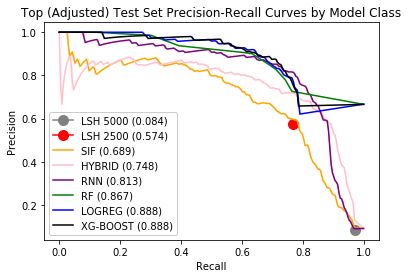

In [101]:
# Plot best performance per model class
# Get best model performances across samplers and blockers
best_per_model = all_results[["sampler_m","blocking_algo_m","model","test_precision","test_recall_m","test_average_precision"]].groupby(["model"])["test_average_precision"].apply(lambda x: x.nlargest(1)).sort_values()
best_per_model = pd.DataFrame(best_per_model).reset_index()
best_per_model = best_per_model.sort_values("test_average_precision")

colours = {"RF":"green","LogReg":"blue","Xg-Boost":"black","sif":"orange","rnn":"purple","hybrid":"pink"}

all_results["id_string"] = all_results.index.astype(str)

#Plot LSH blockers as if they were a model
plt.plot(test_recall_5000_lsh ,precision_5000_lsh, marker="o", ms=10, markevery=[0], color = "gray",label = f"LSH 5000 ({round(precision_5000_lsh,3)})")


plt.plot(test_recall_2500_lsh ,precision_2500_lsh, marker="o", ms=10, markevery=[0], color = "red", label = f"LSH 2500 ({round(precision_2500_lsh,3)})")


for id_val in best_per_model.index:
    # Get model description
    model_name = best_per_model.ix[id_val,"model"]
    avg_precision  = round(best_per_model.iloc[id_val,:].test_average_precision,3)
    label_val = f"{model_name.upper()} ({avg_precision})"
    # Prepare Querying Strings
    blocking_id = str(best_per_model.ix[id_val,"id"])
    test_precision = all_results.loc[(all_results.id_string == blocking_id) & (all_results.model == model_name),"test_precision"][0]
    test_recall = all_results.loc[(all_results.id_string == blocking_id) & (all_results.model == model_name),"test_recall_m"][0]

    ax = sns.lineplot(y = test_precision , x = test_recall, color = colours[model_name], label = label_val)

ax.set(ylabel="Precision", xlabel = "Recall", title = "Top (Adjusted) Test Set Precision-Recall Curves by Model Class")



plt.legend(framealpha=1, frameon=True)

plt.show()

In [66]:
best_per_model

,model,id,test_average_precision
0,sif,iterativelshNANA85000,0.688574
1,hybrid,iterativelshNANA85000,0.748115
2,rnn,iterativelshNANA85000,0.812697
3,RF,iterativelshNANA82500,0.866911
4,LogReg,naivelshNANA82500,0.888037
5,Xg-Boost,iterativelshNANA82500,0.888196


When you are reducing the threshold, you will never decrease the recall (you can only flag more of the positive examples as positive). Precision is looking at all the examples that you flag positively, and of those the fraction that are truly positive. This means when you are reducing the threshold, you might not add any true positives but only false positives, thereby lowering your precision. Let's take a look at a fabricated example, where P is positive and N is negative. The samples are ranked by score/probability. Everything before the threshold is flagged as positive:

In [88]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

In [23]:
# all_results.to_excel("output.xlsx")